<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

<img src="https://avatars.githubusercontent.com/u/63704085?s=400&u=5dc6c45b7d457ce6f303fbc612091cb2c133482f&v=4"
     alt="SAR2Cube logo"
     style="float: right; max-width: 200px" />
# SAR2Cube and openEO - SAR Interferometric Coherence data on-the-fly
Author michele.claus@eurac.edu

Date: 2022/10/24

Updated: 2023/05/15

## Useful links:

SAR2Cube website: https://sar2cube.projects.eurac.edu/

openEO main website: https://openeo.org/

openEO Python Client documentation: https://open-eo.github.io/openeo-python-client/index.html

Getting started guide for openEO with python: https://openeo.org/documentation/1.0/python/

## Topics
- Login to Eurac's openEO backend containing the SAR2Cube data sets
- Create an openEO process graph to compute the interferometric coherence
- Create an openEO batch job and monitor it
- Download and visualize the results

## Import all the libraries and utilities functions
The ones included in the eo_utils.py file are needed for the ipyleaflet interactive map

Please check to have the latest `openeo` library. Please check here for the latest available version: https://pypi.org/project/openeo/

In [10]:
import os
import openeo
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## SAR2Cube available data collections
### Doñana Datacubes:
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA
SAR2Cube_SInCohMap_S1_L0_154_DSC_DONYANA
```
Sentinel-2:
```
SInCohMap_S2_L1C_T29SQB
```
### South Tyrol Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL
SAR2Cube_SInCohMap_S1_L0_168_DSC_SOUTH_TYROL
```
Sentinel-2:
```
S2_L1C_T32TPS
```
### Finland Datacubes
Sentinel-1:
```
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI1
SAR2Cube_SInCohMap_S1_L0_80_DSC_FINLAND_AOI2
```

## Interferometric Coherence


Firstly download a tiny subset of the datacube for the whole timeseries.

With the downloaded netCDF we can extract the available dates and compute the master-slave pairs for the given temporal baseline.

**Please note: this step is not necessary since sample netCDFs with the vailable dates are already provided in the GitHub repo in the aux_data folder.**

The available netCDFs containing the dates for the SInCohMap Sentinel-1 datacubes are:
```
./aux_data/Donyana_ASC_147_dates.nc
./aux_data/Donyana_DSC_154_dates.nc
./aux_data/Finland_AOI1_dates.nc
./aux_data/Finland_AOI1_dates.nc
./aux_data/South_Tyrol_DSC_168_dates.nc
./aux_data/South_Tyrol_ASC_117_dates.nc
```

In [11]:
# conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
# spatial_extent  = {'west':-6.094129 ,'east':-6.091833 ,'south':37.115613 ,'north':37.117239}
# collection      = 'SAR2Cube_SInCohMap_S1_L0_147_ASC_DONYANA'
# # Not specifying the temporal extent will load the whole timeseries
# bands = ['grid_lon','grid_lat']
# S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

In [12]:
# %%time
# S1_slant_range.download('./aux_data/Donyana_ASC_147_dates.nc')

## AOI
We usa a sample AOI over Bolzano, South Tyrol, Italy

In [13]:
spatial_extent = {'west': 11.286736, 'east': 11.377029, 'south': 46.463309, 'north': 46.513185}

Compute the master-slave pairs for the given temporal baseline.

Read the retrieved netCDF containing the timestamps:

In [14]:
dates_netcdf = xr.open_dataarray('./aux_data/South_Tyrol_ASC_117_dates.nc')
dates_netcdf.time

<xarray.DataArray 'time' (time: 313)>
array(['2016-09-08T05:27:59.000000000', '2016-09-08T23:59:59.000000000',
       '2016-09-20T05:27:59.000000000', ..., '2022-07-27T05:27:59.000000000',
       '2022-08-08T05:27:59.000000000', '2022-08-20T05:27:59.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2016-09-08T05:27:59 ... 2022-08-20T05:...
    spatial_ref  int64 ...

Coherence temporal baseline. Ideally you can use values that are multiple of 6.

However, when using data from January 2022 onwards only 12 days is possible since we lost Sentinel-1B.

In [15]:
timedelta = 12

We want to compute the coherence for January 2022. (Please try a small temporal extent firstly)

In [16]:
timesteps = dates_netcdf['time'].loc[dict(time=slice('2022-01-01','2022-01-16'))].values
print("First date available for 2022: ",timesteps[0])
print("Last date available for 2021:  ",timesteps[-1])

First date available for 2022:  2022-01-04T05:27:59.000000000
Last date available for 2021:   2022-01-16T05:27:59.000000000


We loop through the timesteps and check where we have 6 or 12 or ... days pairs of dates

In [17]:
dates_pair = []
for i,t in enumerate(timesteps[:-1]):
    for t2 in timesteps[i+1:]:
        if(np.timedelta64(t2 - t, 'D')) == np.timedelta64(timedelta,'D'):
            dates_pair.append([t,t2])
print("First date pair: ",dates_pair[0])
print("Last date pair:  ",dates_pair[-1])

First date pair:  [numpy.datetime64('2022-01-04T05:27:59.000000000'), numpy.datetime64('2022-01-16T05:27:59.000000000')]
Last date pair:   [numpy.datetime64('2022-01-04T05:27:59.000000000'), numpy.datetime64('2022-01-16T05:27:59.000000000')]


We define new temporal labels containing the master and slave dates:

In [18]:
mst_slv_temporal_labels = [ str(i[0])[:10] + "_" + str(i[1])[:10] for i in dates_pair]
mst_slv_temporal_labels.reverse()
print("The output will have a temporal label named like this: ",mst_slv_temporal_labels[0])

The output will have a temporal label named like this:  2022-01-04_2022-01-16


We now got the master-slave date pairs which will be used to compute the coherence.

Now we define the utility functions for computing the complex coherence and then its amplitude

In [19]:
from openeo.processes import ProcessBuilder, array_element

def compute_real_part_numerator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VV_mst")
    q_mst = array_element(x,label="q_VV_mst")
    i_slv = array_element(x,label="i_VV_slv")
    q_slv = array_element(x,label="q_VV_slv")
    return (i_mst*i_slv + q_mst*q_slv)

def compute_imag_part_numerator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VV_mst")
    q_mst = array_element(x,label="q_VV_mst")
    i_slv = array_element(x,label="i_VV_slv")
    q_slv = array_element(x,label="q_VV_slv")
    return (q_mst*i_slv - i_mst*q_slv)

def compute_real_part_numerator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VH_mst")
    q_mst = array_element(x,label="q_VH_mst")
    i_slv = array_element(x,label="i_VH_slv")
    q_slv = array_element(x,label="q_VH_slv")
    return (i_mst*i_slv + q_mst*q_slv)

def compute_imag_part_numerator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VH_mst")
    q_mst = array_element(x,label="q_VH_mst")
    i_slv = array_element(x,label="i_VH_slv")
    q_slv = array_element(x,label="q_VH_slv")
    return (q_mst*i_slv - i_mst*q_slv)

def compute_mst_denominator_VV(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VV_mst")
    q_mst = array_element(x,label="q_VV_mst")
    return (i_mst**2+q_mst**2)

def compute_slv_denominator_VV(x:ProcessBuilder):
    i_slv = array_element(x,label="i_VV_slv")
    q_slv = array_element(x,label="q_VV_slv")
    return (i_slv**2+q_slv**2)

def compute_mst_denominator_VH(x:ProcessBuilder):
    i_mst = array_element(x,label="i_VH_mst")
    q_mst = array_element(x,label="q_VH_mst")
    return (i_mst**2+q_mst**2)

def compute_slv_denominator_VH(x:ProcessBuilder):
    i_slv = array_element(x,label="i_VH_slv")
    q_slv = array_element(x,label="q_VH_slv")
    return (i_slv**2+q_slv**2)

def compute_coherence_amplitude_VV(x:ProcessBuilder):
    q_num_VV = array_element(x,label="q_num_VV")
    i_num_VV = array_element(x,label="i_num_VV")
    mst_den = array_element(x,label="mst_den")
    slv_den = array_element(x,label="slv_den")
    
    coh_i = i_num_VV / ((mst_den * slv_den + 1e-12)**0.5)
    coh_q = q_num_VV / ((mst_den * slv_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

def compute_coherence_amplitude_VH(x:ProcessBuilder):
    q_num_VH = array_element(x,label="q_num_VH")
    i_num_VH = array_element(x,label="i_num_VH")
    mst_den = array_element(x,label="mst_den")
    slv_den = array_element(x,label="slv_den")
    
    coh_i = i_num_VH / ((mst_den * slv_den + 1e-12)**0.5)
    coh_q = q_num_VH / ((mst_den * slv_den + 1e-12)**0.5)
    
    return (coh_i**2+coh_q**2)**0.5

Coherence parameters:

In [20]:
# Multi-look filter
range_looks   = 19
azimuth_looks = 4

# Geocoding
resolution = 20 # can be 10, 20 or 60 meters, it will be aligned with the Sentinel-2 grid
crs = 32632

# Datacube
collection      = "SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL"

# openEO Eurac back-end
openeoHost = "https://openeo.eurac.edu"

In [21]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
bands = ["grid_lon","grid_lat","i_VV","q_VV","i_VH","q_VH"]
S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands)

# We use a loop over the dates we want to request and a combination of filter_temporal + merge_cubes to get only the dates we want:
for i,date_pair in enumerate(dates_pair):
    # The requested date until the day after, since openEO excludes the end date
    mst_date = date_pair[0]
    slv_date = date_pair[1]
    mst_temporal_extent = [str(mst_date),str(mst_date + np.timedelta64(1, "D"))]
    slv_temporal_extent = [str(slv_date),str(slv_date + np.timedelta64(1, "D"))]

    if i == 0:
        S1_slant_range_mst_bands = S1_slant_range.filter_temporal(mst_temporal_extent)
        S1_slant_range_slv_bands = S1_slant_range.filter_temporal(slv_temporal_extent)
    else:
        S1_slant_range_mst_bands = S1_slant_range.filter_temporal(mst_temporal_extent).merge_cubes(S1_slant_range_mst_bands)
        S1_slant_range_slv_bands = S1_slant_range.filter_temporal(slv_temporal_extent).merge_cubes(S1_slant_range_slv_bands)

Authenticated using refresh token.


In [22]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.filter_bands(["i_VV","q_VV","i_VH","q_VH"])
S1_slant_range_slv_bands = S1_slant_range_slv_bands.filter_bands(["i_VV","q_VV","i_VH","q_VH"])

We rename the temporal labels to facilitate the next steps of the coherence computation:

In [23]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.rename_labels(dimension="DATE",
                                                                 target=mst_slv_temporal_labels)
S1_slant_range_slv_bands = S1_slant_range_slv_bands.rename_labels(dimension="DATE",
                                                                 target=mst_slv_temporal_labels)

We rename the bands according to the master/slave members

In [24]:
S1_slant_range_mst_bands = S1_slant_range_mst_bands.rename_labels(dimension="bands",
                                                                  source=["i_VV","q_VV","i_VH","q_VH"],
                                                                  target=["i_VV_mst","q_VV_mst","i_VH_mst","q_VH_mst"])
S1_slant_range_slv_bands = S1_slant_range_slv_bands.rename_labels(dimension="bands",
                                                                  source=["i_VV","q_VV","i_VH","q_VH"],
                                                                  target=["i_VV_slv","q_VV_slv","i_VH_slv","q_VH_slv"])

Merge the two datacubes into a single one

In [25]:
S1_slant_range_mst_slv_bands = S1_slant_range_mst_bands.merge_cubes(S1_slant_range_slv_bands)

Compute the coherence numerator for VV and VH

In [26]:
i_numerator_VV = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",reducer=compute_real_part_numerator_VV)
q_numerator_VV = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",reducer=compute_imag_part_numerator_VV)

i_numerator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",reducer=compute_real_part_numerator_VH)
q_numerator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",reducer=compute_imag_part_numerator_VH)

Apply multilook to real and imaginary part of the numerator using the `aggregate_spatial_window` openEO process. More info here: https://processes.openeo.org/#aggregate_spatial_window

In [27]:
i_numerator_VV_ML = i_numerator_VV.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")
q_numerator_VV_ML = q_numerator_VV.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")

i_numerator_VH_ML = i_numerator_VH.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")
q_numerator_VH_ML = q_numerator_VH.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")

Compute the coherence denominator for VV and VH

In [28]:
mst_denominator_VV = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",reducer=compute_mst_denominator_VV)
slv_denominator_VV = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",reducer=compute_slv_denominator_VV)

mst_denominator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",reducer=compute_mst_denominator_VH)
slv_denominator_VH = S1_slant_range_mst_slv_bands.reduce_dimension(dimension="bands",reducer=compute_slv_denominator_VH)

Apply multilook to the denominator

In [29]:
mst_denominator_VV_ML = mst_denominator_VV.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")
slv_denominator_VV_ML = slv_denominator_VV.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")

mst_denominator_VH_ML = mst_denominator_VH.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")
slv_denominator_VH_ML = slv_denominator_VH.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")

Merge all the bands for VV

In [30]:
i_numerator_VV_ML = i_numerator_VV_ML.add_dimension(name="bands",label="i_num_VV")
q_numerator_VV_ML = q_numerator_VV_ML.add_dimension(name="bands",label="q_num_VV")

mst_denominator_VV_ML = mst_denominator_VV_ML.add_dimension(name="bands",label="mst_den")
slv_denominator_VV_ML = slv_denominator_VV_ML.add_dimension(name="bands",label="slv_den")

coh_numerator_denominator_VV = i_numerator_VV_ML.merge_cubes(q_numerator_VV_ML).merge_cubes(mst_denominator_VV_ML).merge_cubes(slv_denominator_VV_ML)

Merge all the bands for VH

In [31]:
i_numerator_VH_ML = i_numerator_VH_ML.add_dimension(name="bands",label="i_num_VH")
q_numerator_VH_ML = q_numerator_VH_ML.add_dimension(name="bands",label="q_num_VH")

mst_denominator_VH_ML = mst_denominator_VH_ML.add_dimension(name="bands",label="mst_den")
slv_denominator_VH_ML = slv_denominator_VH_ML.add_dimension(name="bands",label="slv_den")

coh_numerator_denominator_VH = i_numerator_VH_ML.merge_cubes(q_numerator_VH_ML).merge_cubes(mst_denominator_VH_ML).merge_cubes(slv_denominator_VH_ML)

Compute the coherence amplitude

In [32]:
coh_VV = coh_numerator_denominator_VV.reduce_dimension(dimension="bands",reducer=compute_coherence_amplitude_VV)
coh_VV = coh_VV.add_dimension(name="bands",label="coh_vv_amp")

coh_VH = coh_numerator_denominator_VH.reduce_dimension(dimension="bands",reducer=compute_coherence_amplitude_VH)
coh_VH = coh_VH.add_dimension(name="bands",label="coh_vh_amp")

Merge VV and VH

In [33]:
coh_amplitude = coh_VH.merge_cubes(coh_VV)

Apply geocoding. We choose 20m resolution for the pixel size and the local UTM zone as projection.

We can choose only from 10, 20 or 60m for resolution, for being able to align the data with Sentinel-2 grid.

This process is not yet an official openEO process and therefore the syntax to apply it is not streamlined as with the other processes.

In [34]:
lat_lon_grids = S1_slant_range.filter_bands(["grid_lon","grid_lat"]).reduce_dimension(dimension="DATE",reducer="mean")
lat_lon_grids = lat_lon_grids.aggregate_spatial_window(size=[range_looks,azimuth_looks],reducer="mean")

coh_amplitude = coh_amplitude.merge_cubes(lat_lon_grids)

args_geocoding = {"resolution":resolution,"crs":crs}
coh_amplitude_geocoded = coh_amplitude.process("geocode",args_geocoding, data=coh_amplitude)

coh_amplitude_geocoded_nc = coh_amplitude_geocoded.save_result(format="netCDF")

Create a batch job and start it

In [41]:
job = conn.create_job(coh_amplitude_geocoded_nc,title="SAR2CUBE_ASC_coherence_12days")
job_id = job.job_id
print("Batch job created with id: ",job_id)
job.start_job()

Batch job created with id:  df02ae4f-5af9-40ee-9113-2bdce5229809


Visualize the job status

In [40]:
job = conn.job(job_id)
job

<BatchJob job_id='df02ae4f-5af9-40ee-9113-2bdce5229809'>

Create the output folder to store the results:

In [41]:
import os
result_dir_name = "coherence_results"
if not os.path.exists(result_dir_name):
    os.mkdir(result_dir_name)

Once the job is marked as finished, you can download the result.

Either via the download link provided in the following visualization:

In [42]:
result = job.get_results()
result

<JobResults for job 'df02ae4f-5af9-40ee-9113-2bdce5229809'>

Or via python code specifying the target location:

In [43]:
result.download_files(result_dir_name + "/")

[PosixPath('coherence_results/process.json'),
 PosixPath('coherence_results/result.nc'),
 PosixPath('coherence_results/job-results.json')]

Loading the netCDF using xArray

In [44]:
result = xr.open_dataarray(result_dir_name + "/result.nc",decode_coords="all")
result

<xarray.DataArray (variable: 2, time: 1, y: 286, x: 353)>
[201916 values with dtype=float32]
Coordinates:
  * y            (y) float32 5.148e+06 5.148e+06 ... 5.154e+06 5.154e+06
  * x            (x) float32 6.752e+05 6.753e+05 ... 6.823e+05 6.823e+05
  * time         (time) object '2022-01-04_2022-01-16'
  * variable     (variable) object 'coh_vh_amp' 'coh_vv_amp'
    spatial_ref  int64 ...

Visualize the result with matplotlib

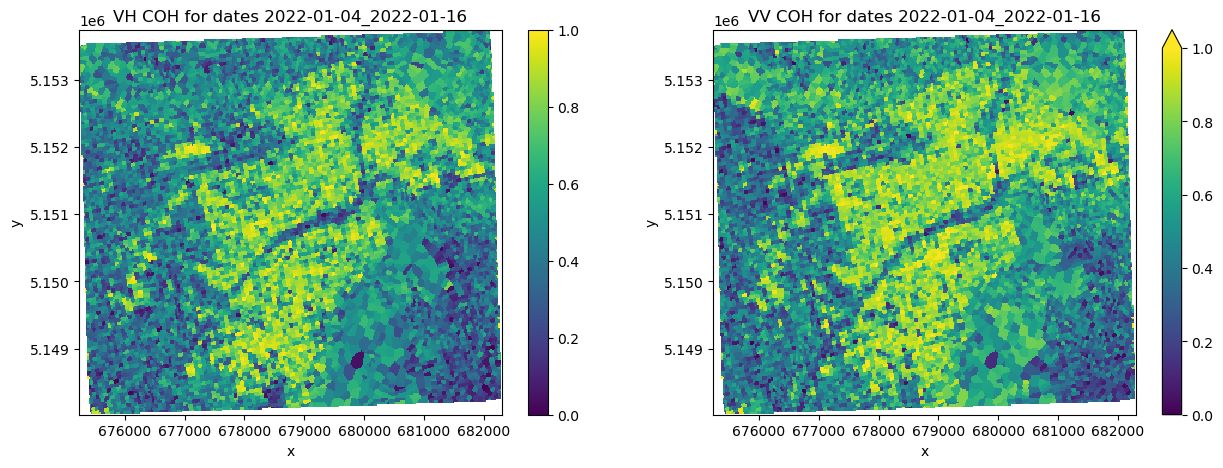

In [45]:
# plot_args = {'cmap':'Greys_r','add_colorbar':False}
plot_args = {}
fig, ax = plt.subplots(1,2,figsize=(15,5))
result.loc[dict(variable="coh_vh_amp")][0].plot.imshow(ax=ax[0],**plot_args, vmin=0,vmax=1)
ax[0].set_title("VH COH for dates " + str(result.loc[dict(variable="coh_vh_amp")]["time"][0].values))
result.loc[dict(variable="coh_vv_amp")][0].plot.imshow(ax=ax[1],**plot_args, vmin=0,vmax=1)
ax[1].set_title("VV COH for dates " + str(result.loc[dict(variable="coh_vv_amp")]["time"][0].values))
plt.show()